# Задача об переворачивании математического маятника
в статье, приведенной мне по ссылке: https://www.gymlibrary.ml/environments/classic_control/pendulum/?highlight=pendulum, не уточняется какой именно маятник,
но пусть он будет математическим с начльными условиями:
$l = 1, m = 1, \theta_1 = \theta_0, \omega_1 =\omega_0 $
Задача состоит в том, что бы перевернуть его в верхнее положение и удерживать его там.
Для этого воспользуемся PID регулятором:


Уравнения:

$ml^2\ddot{\theta} + mglsin(\theta) = u \newline
\left\{ \begin{gathered}
\dot{\theta}_0 = \theta_1\\
\dot{\theta}_1 = \frac{u - mglsin(\theta_0)}{l^2m}
\end{gathered}  \right.$

In [215]:
#Начальное значение
from math import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt




class Params:

    def __init__(self):

        self.m = 1
        self.l = 1
        self.g = 9.8


In [216]:


def rhs(t, th, p, u):
    
    dthdt = np.zeros(2)
    dthdt[0] = th[1]
    dthdt[1] = (u - p.m*p.g*p.l*sin(th[0]))/(p.l**2*p.m)
    return dthdt


In [217]:
class PID_Controller():
    def __init__(self, dt, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.integral = 0
        self.e_prev = None

    def update(self, state, reference):
        error = state - reference
        if self.e_prev is None:
            dedt = 0
        else:
            # первый порядок апроксимации
            dedt = (error - self.e_prev) / self.dt
        
        self.integral = self.integral + error * self.dt

        self.e_prev = error
        return self.kp * error + self.ki * self.integral + self.kd * dedt


In [218]:


def ra(t):
    return pi/2


# Решатель
def solve(t0, tf, dt, th0, p, pid1):
    time = np.arange(t0, tf, dt)
    result = th0
    force = []
    
    for i in range(len(time) - 1):
        
        u = pid1.update(th0[0], ra(time[i]))
        force = np.append(force, u)
        solution = solve_ivp(lambda t, th: rhs(t, th, p, u), (time[i], time[i + 1]), th0)
        th0 = solution.y[:, -1]
    
        if abs(th0[0]) > pi:
            th0[0] = pi* np.sign(th0[0])
        result = np.vstack((result, th0))
    
    return time, force, result

In [219]:
t_0 = 0
t_f = 100
d_t = 0.01
init = [1.32, 1.56]
param = Params()

pid1 = PID_Controller(d_t, 2, 0, 1)


[t, f, theta] = solve(t_0, t_f, d_t, init, param, pid1)

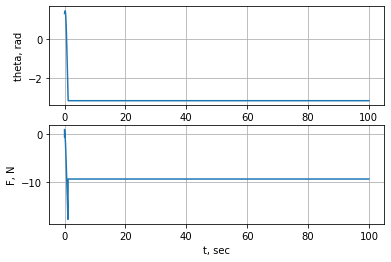

In [220]:


ax = plt.subplot(2,1,1)

ax.plot(t, theta[:,0])
ax.set_xlabel('t, sec')
ax.set_ylabel('theta, rad')
ax.grid()


ax = plt.subplot(2, 1, 2)
ax.plot(t[0:-1], f)
ax.set_xlabel('t, sec')
ax.set_ylabel('F, N')
ax.grid()

plt.savefig("file1.jpeg")
